# Artistic - Syntactic & Semantic Feature Extraction (Local MacBook Pro)

This notebook runs locally on MacBook Pro with hardware optimizations.

**Hardware:** MacBook Pro 15" 2018 with Radeon Pro 555X  
**Optimizations:** Multi-threaded CPU processing with 8 cores

**Features:**
- 26 comprehensive syntactic and semantic features
- Full preprocessing pipeline
- Model training with multiple classifiers
- Extensive visualizations and analysis

**Author:** Randil Haturusinghe

## 1. Setup and Hardware Configuration

In [1]:
# Import optimization configuration
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")

# Set environment variables for optimal CPU performance
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['OPENBLAS_NUM_THREADS'] = '8'
os.environ['VECLIB_MAXIMUM_THREADS'] = '8'

print("\nEnvironment configured for 8-thread CPU processing")

Project root: /Users/user/PycharmProjects/Artistic.
Python version: 3.8.10 (v3.8.10:3d8993a744, May  3 2021, 08:55:58) 
[Clang 6.0 (clang-600.0.57)]

Environment configured for 8-thread CPU processing


In [2]:
# Check hardware capabilities
import psutil
import platform

print("System Information:")
print("=" * 70)
print(f"Platform: {platform.platform()}")
print(f"Processor: {platform.processor()}")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count(logical=True)} logical")
print(f"Total RAM: {psutil.virtual_memory().total / (1024 ** 3):.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / (1024 ** 3):.1f} GB")
print(f"CPU Frequency: {psutil.cpu_freq().current:.0f} MHz")
print("=" * 70)

# Check GPU acceleration
try:
    import torch

    print(f"\nPyTorch version: {torch.__version__}")
    if torch.backends.mps.is_available():
        print("✓ Metal Performance Shaders (MPS) is AVAILABLE")
        print("  GPU acceleration enabled for compatible operations")
        
        # Set default device to MPS
        if not torch.backends.mps.is_built():
            print("  ⚠ MPS not built in this PyTorch version")
        else:
            # Create a test tensor to verify MPS works
            try:
                test_tensor = torch.ones(1, device="mps")
                print(f"  ✓ MPS device initialized successfully: {test_tensor.device}")
                MPS_DEVICE = torch.device("mps")
                USE_GPU = True
            except Exception as e:
                print(f"  ⚠ MPS initialization failed: {e}")
                MPS_DEVICE = torch.device("cpu")
                USE_GPU = False
    else:
        print("⚠ MPS not available, using optimized CPU")
        MPS_DEVICE = torch.device("cpu")
        USE_GPU = False
except ImportError:
    print("⚠ PyTorch not installed")
    MPS_DEVICE = None
    USE_GPU = False
except Exception as e:
    print(f"⚠ Error checking GPU: {e}")
    MPS_DEVICE = None
    USE_GPU = False

if USE_GPU:
    print(f"\n{'='*70}")
    print(f"🚀 GPU ACCELERATION ENABLED - Using device: {MPS_DEVICE}")
    print(f"{'='*70}")

System Information:
Platform: macOS-10.16-x86_64-i386-64bit
Processor: i386
CPU Cores: 6 physical, 12 logical
Total RAM: 16.0 GB
Available RAM: 5.4 GB
CPU Frequency: 2200 MHz
⚠ Error checking GPU: module 'torch' has no attribute '__version__'


## 2. Import Libraries

In [3]:
# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Use non-interactive backend initially, switch to interactive for display
matplotlib.use('Agg')  # For safety
%matplotlib inline

# Try to use interactive backend if available
try:
    from IPython.display import display, HTML
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.offline as pyo

    pyo.init_notebook_mode(connected=True)
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Plotly not available, using matplotlib only")
    PLOTLY_AVAILABLE = False

from typing import List, Dict, Any
from tqdm.notebook import tqdm
import joblib

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

print("✓ Libraries imported successfully!")
print(f"  - pandas: {pd.__version__}")
print(f"  - numpy: {np.__version__}")
print(f"  - matplotlib: {matplotlib.__version__}")
print(f"  - seaborn: {sns.__version__}")
if PLOTLY_AVAILABLE:
    print(f"  - plotly: ")

✓ Libraries imported successfully!
  - pandas: 2.0.0
  - numpy: 1.24.0
  - matplotlib: 3.7.0
  - seaborn: 0.12.0
  - plotly: 


In [4]:
# Import project modules with error handling
try:
    from src.parsers.chat_parser import CHATParser, TranscriptData
    from src.features.feature_extractor import FeatureExtractor
    from src.features.syntactic_semantic import SyntacticSemanticFeatures
    from src.models.syntactic_semantic import SyntacticSemanticPreprocessor, SyntacticSemanticTrainer
    from src.models.syntactic_semantic.model_trainer import SyntacticSemanticModelConfig
    from config import config

    print("✓ Project modules imported successfully!")
except ImportError as e:
    print(f"✗ Error importing project modules: {e}")
    print("\nPlease ensure you're running this from the project root directory.")
    print(f"Current directory: {os.getcwd()}")
    print("\nNote: You may need to restart the kernel and ensure all dependencies are installed.")
    import traceback
    traceback.print_exc()

2025-12-24 00:14:20 | INFO     | src.utils.logger:setup_logger - Logger initialized - Level: INFO, File: logs/asd_detection.log


✓ Project modules imported successfully!


## 3. Configure Optimal Performance Settings

In [5]:
# Optimal settings for MacBook Pro 2018
N_JOBS = 8  # Use 8 threads for parallel processing

# Configure for each library
XGBOOST_PARAMS = {
    'tree_method': 'hist',
    'n_jobs': N_JOBS,
    'max_bin': 256
}

LIGHTGBM_PARAMS = {
    'n_jobs': N_JOBS,
    'num_threads': N_JOBS,
    'force_col_wise': True,
    'verbose': -1
}

SKLEARN_PARAMS = {
    'n_jobs': N_JOBS
}

print("Performance Settings:")
print(f"  Parallel jobs: {N_JOBS}")
print(f"  XGBoost: optimized histogram method")
print(f"  LightGBM: column-wise optimization")
print(f"  scikit-learn: multi-threaded")

Performance Settings:
  Parallel jobs: 8
  XGBoost: optimized histogram method
  LightGBM: column-wise optimization
  scikit-learn: multi-threaded


## 4. Data Loading and Exploration

In [6]:
# Find available datasets
data_dir = Path("data")

print("Scanning for datasets...")
print("=" * 70)

datasets = []
if data_dir.exists():
    for dataset_path in sorted(data_dir.glob("asdbank_*")):
        cha_files = list(dataset_path.rglob("*.cha"))
        if cha_files:
            datasets.append({
                'name': dataset_path.name,
                'path': dataset_path,
                'file_count': len(cha_files)
            })
            print(f"  ✓ {dataset_path.name}: {len(cha_files)} files")

if not datasets:
    print("  ✗ No datasets found")
    print(f"\nPlease ensure .cha files are in: {data_dir.absolute()}")
else:
    print("\n" + "=" * 70)
    print(f"Total datasets: {len(datasets)}")
    print(f"Total files: {sum(d['file_count'] for d in datasets)}")
    print("=" * 70)

Scanning for datasets...
  ✓ asdbank_aac: 83 files
  ✓ asdbank_eigsti: 48 files
  ✓ asdbank_flusberg: 64 files
  ✓ asdbank_nadig: 38 files
  ✓ asdbank_quigley_mcnalley: 203 files
  ✓ asdbank_rollins: 21 files

Total datasets: 6
Total files: 457


In [7]:
# Select dataset(s) to process
# You can modify this to select specific datasets

selected_datasets = []

# Option 1: Process ALL datasets
selected_datasets = datasets

# Option 2: Select specific datasets by name (uncomment to use)
# selected_names = ['asdbank_eigsti', 'asdbank_aac']
# selected_datasets = [d for d in datasets if d['name'] in selected_names]

# Fallback: Try to find Eigsti dataset first (if no other selection)
if not selected_datasets:
    for dataset in datasets:
        if 'eigsti' in dataset['name'].lower():
            selected_datasets.append(dataset)
            break

    # If not found, use the first available dataset
    if not selected_datasets and datasets:
        selected_datasets.append(datasets[0])

if selected_datasets:
    print("Selected datasets for processing:")
    for ds in selected_datasets:
        print(f"  - {ds['name']}: {ds['file_count']} files")
else:
    print("No datasets selected!")

Selected datasets for processing:
  - asdbank_aac: 83 files
  - asdbank_eigsti: 48 files
  - asdbank_flusberg: 64 files
  - asdbank_nadig: 38 files
  - asdbank_quigley_mcnalley: 203 files
  - asdbank_rollins: 21 files


## 5. Feature Extraction

In [8]:
# Initialize feature extractor
print("Initializing syntactic/semantic feature extractor...")

try:
    extractor = FeatureExtractor(categories=['syntactic_semantic'])
    
    print("\n✓ Feature extractor initialized!")
    print(f"  Active categories: {extractor.active_categories}")
    print(f"  Total features: {len(extractor.all_feature_names)}")
    
    print("\nFeatures to extract:")
    for i, name in enumerate(extractor.all_feature_names, 1):
        print(f"  {i:2d}. {name}")
        
except Exception as e:
    print(f"\n✗ Error initializing extractor: {e}")
    print("  Failed to initialize feature extractor. Check the error above.")
    import traceback
    traceback.print_exc()

Initializing syntactic/semantic feature extractor...


2025-12-24 00:14:26 | INFO     | src.features.syntactic_semantic.syntactic_semantic:__init__ - SyntacticSemanticFeatures initialized
2025-12-24 00:14:26 | INFO     | src.features.feature_extractor:__init__ - FeatureExtractor initialized with categories: ['syntactic_semantic']
2025-12-24 00:14:26 | INFO     | src.features.feature_extractor:__init__ - Include placeholders: True



✓ Feature extractor initialized!
  Active categories: ['syntactic_semantic']
  Total features: 26

Features to extract:
   1. avg_dependency_depth
   2. max_dependency_depth
   3. avg_dependency_distance
   4. clause_complexity
   5. subordination_index
   6. coordination_index
   7. grammatical_error_rate
   8. tense_consistency_score
   9. tense_variety
  10. structure_diversity
  11. pos_tag_diversity
  12. avg_parse_tree_height
  13. noun_phrase_complexity
  14. verb_phrase_complexity
  15. prepositional_phrase_ratio
  16. semantic_coherence
  17. semantic_density
  18. lexical_diversity_semantic
  19. thematic_consistency
  20. vocabulary_abstractness
  21. semantic_field_diversity
  22. word_sense_diversity
  23. content_word_ratio
  24. semantic_role_diversity
  25. entity_density
  26. verb_argument_complexity


In [9]:
# Extract features from selected datasets
all_features = []

if selected_datasets:
    print("Starting feature extraction...")
    print("=" * 70)

    for dataset in selected_datasets:
        print(f"\nProcessing: {dataset['name']}")
        print(f"Files: {dataset['file_count']}")

        try:
            file_paths = list(dataset['path'].rglob("*.cha"))

            # Extract features with progress bar
            features_df = extractor.extract_from_files(
                file_paths,
                show_progress=True
            )

            if not features_df.empty:
                features_df['dataset'] = dataset['name']
                all_features.append(features_df)
                print(f"  ✓ Extracted {len(features_df)} samples")
            else:
                print(f"  ⚠ No features extracted")

        except Exception as e:
            print(f"  ✗ Error: {e}")
            import traceback

            traceback.print_exc()

    # Combine all features
    if all_features:
        features_df = pd.concat(all_features, ignore_index=True)
        print("\n" + "=" * 70)
        print(f"✓ Feature extraction complete!")
        print(f"  Total samples: {len(features_df)}")
        print(f"  Total features: {len([c for c in features_df.columns if c in extractor.all_feature_names])}")
        print("=" * 70)
    else:
        print("\n✗ No features extracted!")
        features_df = pd.DataFrame()
else:
    print("No datasets to process!")
    features_df = pd.DataFrame()

2025-12-24 00:14:26 | INFO     | src.parsers.chat_parser:__init__ - CHATParser initialized with min_words=1
Extracting features:   0%|          | 0/83 [00:00<?, ?it/s]2025-12-24 00:14:26 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 07_T1_2.cha


Starting feature extraction...

Processing: asdbank_aac
Files: 83


2025-12-24 00:14:26 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 56 utterances from 07_T1_2.cha
Extracting features:   1%|          | 1/83 [00:00<00:42,  1.94it/s]2025-12-24 00:14:26 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 06_T1_2.cha
2025-12-24 00:14:27 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 106 utterances from 06_T1_2.cha
Extracting features:   2%|▏         | 2/83 [00:01<00:42,  1.92it/s]2025-12-24 00:14:27 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 06_T3_1.cha
2025-12-24 00:14:27 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 119 utterances from 06_T3_1.cha
Extracting features:   4%|▎         | 3/83 [00:01<00:48,  1.64it/s]2025-12-24 00:14:27 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 07_T3_1.cha
2025-12-24 00:14:28 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 77 utterances from 07_T3_1.cha
Extracting

  ✓ Extracted 83 samples

Processing: asdbank_eigsti
Files: 48


2025-12-24 00:15:16 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 350 utterances from 1082.cha
Extracting features:   2%|▏         | 1/48 [00:01<01:13,  1.55s/it]2025-12-24 00:15:17 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 1040.cha
2025-12-24 00:15:18 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 496 utterances from 1040.cha
Extracting features:   4%|▍         | 2/48 [00:03<01:30,  1.96s/it]2025-12-24 00:15:19 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 1081.cha
2025-12-24 00:15:20 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 361 utterances from 1081.cha
Extracting features:   6%|▋         | 3/48 [00:05<01:19,  1.76s/it]2025-12-24 00:15:21 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 1047.cha
2025-12-24 00:15:21 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 199 utterances from 1047.cha
Extracting features:   8%|▊  

  ✓ Extracted 48 samples

Processing: asdbank_flusberg
Files: 64


2025-12-24 00:16:39 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 1076 utterances from 060819.cha
Extracting features:   2%|▏         | 1/64 [00:03<03:25,  3.26s/it]2025-12-24 00:16:42 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 060207.cha
2025-12-24 00:16:43 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 1225 utterances from 060207.cha
Extracting features:   3%|▎         | 2/64 [00:06<03:15,  3.16s/it]2025-12-24 00:16:45 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 060011.cha
2025-12-24 00:16:46 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 1310 utterances from 060011.cha
Extracting features:   5%|▍         | 3/64 [00:10<03:32,  3.48s/it]2025-12-24 00:16:49 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 060406.cha
2025-12-24 00:16:50 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 1129 utterances from 060406.cha
Extracting 

  ✓ Extracted 64 samples

Processing: asdbank_nadig
Files: 38


2025-12-24 00:19:28 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 253 utterances from 139.cha
Extracting features:   3%|▎         | 1/38 [00:01<00:39,  1.07s/it]2025-12-24 00:19:28 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 111.cha
2025-12-24 00:19:29 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 167 utterances from 111.cha
Extracting features:   5%|▌         | 2/38 [00:02<00:36,  1.01s/it]2025-12-24 00:19:29 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 110.cha
2025-12-24 00:19:30 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 231 utterances from 110.cha
Extracting features:   8%|▊         | 3/38 [00:02<00:32,  1.09it/s]2025-12-24 00:19:30 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 104.cha
2025-12-24 00:19:30 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 244 utterances from 104.cha
Extracting features:  11%|█         

  ✓ Extracted 38 samples

Processing: asdbank_quigley_mcnalley
Files: 203


2025-12-24 00:20:04 | WARNING  | src.parsers.chat_parser:parse_file - Skipping file 000718.cha due to alignment error (likely contains 0-prefixed words without morphology): cannot align the utterance and %mor tiers:
Tiers --
{'MOT': '0it 0is not nice .', '%mor': 'part|not 
2025-12-24 00:20:04 | WARNING  | src.features.feature_extractor:extract_from_files - Skipping 000718.cha: no utterances found
Extracting features:   0%|          | 1/203 [00:00<01:38,  2.05it/s]2025-12-24 00:20:04 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 001015.cha
2025-12-24 00:20:04 | WARNING  | src.parsers.chat_parser:parse_file - Skipping file 001015.cha due to alignment error (likely contains 0-prefixed words without morphology): cannot align the utterance and %mor tiers:
Tiers --
{'MOT': "no , 0you can't see anybody .", '%mor':
2025-12-24 00:20:04 | WARNING  | src.features.feature_extractor:extract_from_files - Skipping 001015.cha: no utterances found
Extracting features:   1%|      

  ✓ Extracted 56 samples

Processing: asdbank_rollins
Files: 21


2025-12-24 00:21:39 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 413 utterances from 020800.cha
Extracting features:   5%|▍         | 1/21 [00:01<00:25,  1.26s/it]2025-12-24 00:21:40 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 021100.cha
2025-12-24 00:21:41 | WARNING  | src.parsers.chat_parser:parse_file - Skipping file 021100.cha due to alignment error (likely contains 0-prefixed words without morphology): cannot align the utterance and %mor tiers:
Tiers --
{'INV': '0on 0the shelf .', '%mor': 'noun|shelf 
2025-12-24 00:21:41 | WARNING  | src.features.feature_extractor:extract_from_files - Skipping 021100.cha: no utterances found
Extracting features:  10%|▉         | 2/21 [00:01<00:15,  1.24it/s]2025-12-24 00:21:41 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 030700.cha
2025-12-24 00:21:41 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 422 utterances from 030700.cha
Extracting features:  14

  ✓ Extracted 20 samples

✓ Feature extraction complete!
  Total samples: 309
  Total features: 26


In [10]:
# Unify diagnosis labels: TYP and TD mean the same thing
if not features_df.empty and 'diagnosis' in features_df.columns:
    print("Unifying diagnosis labels...")
    print("=" * 70)
    
    # Show original distribution
    print("\nOriginal diagnosis distribution:")
    print(features_df['diagnosis'].value_counts())
    
    # Map TYP to TD
    features_df['diagnosis'] = features_df['diagnosis'].replace({'TYP': 'TD'})
    
    # Show updated distribution
    print("\nUpdated diagnosis distribution (TYP mapped to TD):")
    print(features_df['diagnosis'].value_counts())
    print("=" * 70)

Unifying diagnosis labels...

Original diagnosis distribution:
diagnosis
ASD    29
TYP    25
TD     16
DD     16
Name: count, dtype: int64

Updated diagnosis distribution (TYP mapped to TD):
diagnosis
TD     41
ASD    29
DD     16
Name: count, dtype: int64


In [11]:
# Quick test of the fixed parser
print("Testing CHAT parser with diagnosis extraction fix...")
print("="*70)

parser = CHATParser()

# Test ASD file
test_asd = "data/asdbank_eigsti/Eigsti/ASD/1082.cha"
transcript_asd = parser.parse_file(test_asd)

print(f"\n✓ ASD Test File: {test_asd}")
print(f"  Participant ID: {transcript_asd.participant_id}")
print(f"  Diagnosis: {transcript_asd.diagnosis}")
print(f"  Age: {transcript_asd.age_months} months")
print(f"  Gender: {transcript_asd.gender}")

# Test TD file
test_td = "data/asdbank_eigsti/Eigsti/TD/1068.cha"
transcript_td = parser.parse_file(test_td)

print(f"\n✓ TD Test File: {test_td}")
print(f"  Participant ID: {transcript_td.participant_id}")
print(f"  Diagnosis: {transcript_td.diagnosis}")
print(f"  Age: {transcript_td.age_months} months")
print(f"  Gender: {transcript_td.gender}")

print("\n" + "="*70)
print("✓ Parser is working correctly!")
print("="*70)

2025-12-24 00:22:09 | INFO     | src.parsers.chat_parser:__init__ - CHATParser initialized with min_words=1
2025-12-24 00:22:09 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 1082.cha


Testing CHAT parser with diagnosis extraction fix...


2025-12-24 00:22:10 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 350 utterances from 1082.cha
2025-12-24 00:22:10 | INFO     | src.parsers.chat_parser:parse_file - Parsing CHAT file: 1068.cha



✓ ASD Test File: data/asdbank_eigsti/Eigsti/ASD/1082.cha
  Participant ID: a-00032788-1
  Diagnosis: ASD
  Age: 60 months
  Gender: male


2025-12-24 00:22:10 | INFO     | src.parsers.chat_parser:parse_file - Successfully parsed 307 utterances from 1068.cha



✓ TD Test File: data/asdbank_eigsti/Eigsti/TD/1068.cha
  Participant ID: a-00032777-1
  Diagnosis: TD
  Age: 46 months
  Gender: male

✓ Parser is working correctly!


### 5.1 Test Parser Fix (verify diagnosis extraction works)

In [12]:
# Display basic information about extracted features
if not features_df.empty:
    print("Dataset Overview:")
    print("=" * 70)

    # Basic info
    print(f"Shape: {features_df.shape}")
    print(f"Columns: {list(features_df.columns[:10])}...")

    # Check for diagnosis column
    if 'diagnosis' in features_df.columns:
        print(f"\nDiagnosis distribution:")
        print(features_df['diagnosis'].value_counts())

    # First few rows
    print("\nFirst few samples:")
    display(features_df.head())

    # Feature statistics
    feature_cols = [c for c in features_df.columns if c in extractor.all_feature_names]
    if feature_cols:
        print("\nFeature Statistics:")
        display(features_df[feature_cols].describe())
else:
    print("No data available for display")

Dataset Overview:
Shape: (309, 31)
Columns: ['participant_id', 'file_path', 'diagnosis', 'age_months', 'avg_dependency_depth', 'max_dependency_depth', 'avg_dependency_distance', 'clause_complexity', 'subordination_index', 'coordination_index']...

Diagnosis distribution:
diagnosis
TD     41
ASD    29
DD     16
Name: count, dtype: int64

First few samples:


,participant_id,file_path,diagnosis,age_months,avg_dependency_depth,max_dependency_depth,avg_dependency_distance,clause_complexity,subordination_index,coordination_index,...,lexical_diversity_semantic,thematic_consistency,vocabulary_abstractness,semantic_field_diversity,word_sense_diversity,content_word_ratio,semantic_role_diversity,entity_density,verb_argument_complexity,dataset
0,a-00082287-0,data/asdbank_aac/AAC/07_T1_2.cha,None,81.0,0.071429,1.0,1.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,asdbank_aac
1,a-00082282-0,data/asdbank_aac/AAC/06_T1_2.cha,None,55.0,0.185185,1.0,1.000000,0.0,0.0,0.0,...,0.5,1.000000,1.000000,0.50,2.000000,0.074074,0.000000,0.000000,0.0,asdbank_aac
2,a-00082284-0,data/asdbank_aac/AAC/06_T3_1.cha,None,55.0,0.510417,3.0,1.255814,0.0,0.0,0.0,...,0.9,0.111111,1.000000,0.25,9.800000,0.208333,0.037736,0.132075,0.6,asdbank_aac
3,a-00082289-0,data/asdbank_aac/AAC/07_T3_1.cha,None,81.0,0.166667,1.0,1.000000,0.0,0.0,0.0,...,1.0,0.000000,0.000000,0.00,0.000000,0.166667,0.000000,0.000000,0.0,asdbank_aac
4,a-00082310-0,data/asdbank_aac/AAC/12_T2.cha,None,57.0,0.360000,1.0,1.000000,0.0,0.0,0.0,...,0.4,0.250000,0.777778,0.30,4.333333,0.200000,0.000000,0.000000,0.0,asdbank_aac



Feature Statistics:


,avg_dependency_depth,max_dependency_depth,avg_dependency_distance,clause_complexity,subordination_index,coordination_index,grammatical_error_rate,tense_consistency_score,tense_variety,structure_diversity,...,semantic_density,lexical_diversity_semantic,thematic_consistency,vocabulary_abstractness,semantic_field_diversity,word_sense_diversity,content_word_ratio,semantic_role_diversity,entity_density,verb_argument_complexity
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,...,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,0.543801,2.466019,1.183069,0.005368,0.039635,0.009559,0.669361,0.473741,0.139636,0.096159,...,0.593014,0.422840,0.264730,0.545661,0.279877,9.517250,0.176761,0.019290,0.069221,0.601961
std,0.409307,2.051997,0.698695,0.017144,0.062994,0.021433,0.346572,0.404079,0.271998,0.115188,...,0.569573,0.314471,0.230042,0.373482,0.223174,7.962369,0.133313,0.025909,0.082204,0.574694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100000,1.000000,1.000000,0.000000,0.000000,0.000000,0.601227,0.000000,0.000000,0.024254,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.559649,2.000000,1.298246,0.000000,0.000000,0.000000,0.781609,0.615385,0.028986,0.062112,...,0.541667,0.437956,0.303030,0.707865,0.306250,11.000000,0.214286,0.011050,0.047619,0.666667
75%,0.886497,4.000000,1.732394,0.000000,0.063584,0.011029,0.941176,0.820896,0.111111,0.125000,...,1.018519,0.588235,0.455357,0.806122,0.416667,14.341584,0.291480,0.028986,0.105556,1.119048
max,1.683150,11.000000,2.556503,0.165644,0.315789,0.223684,1.000000,1.000000,1.000000,1.000000,...,2.697368,1.000000,1.000000,1.000000,1.000000,52.000000,0.401392,0.181818,0.500000,2.000000


## 6. Data Visualization and Analysis

DEBUG: Starting diagnosis distribution block
DEBUG: features_df empty? False
DEBUG: Columns available: ['participant_id', 'file_path', 'diagnosis', 'age_months', 'avg_dependency_depth', 'max_dependency_depth', 'avg_dependency_distance', 'clause_complexity', 'subordination_index', 'coordination_index', 'grammatical_error_rate', 'tense_consistency_score', 'tense_variety', 'structure_diversity', 'pos_tag_diversity', 'avg_parse_tree_height', 'noun_phrase_complexity', 'verb_phrase_complexity', 'prepositional_phrase_ratio', 'semantic_coherence', 'semantic_density', 'lexical_diversity_semantic', 'thematic_consistency', 'vocabulary_abstractness', 'semantic_field_diversity', 'word_sense_diversity', 'content_word_ratio', 'semantic_role_diversity', 'entity_density', 'verb_argument_complexity', 'dataset']
DEBUG: Passed initial checks
DEBUG: First 20 values in diagnosis col:
0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11  

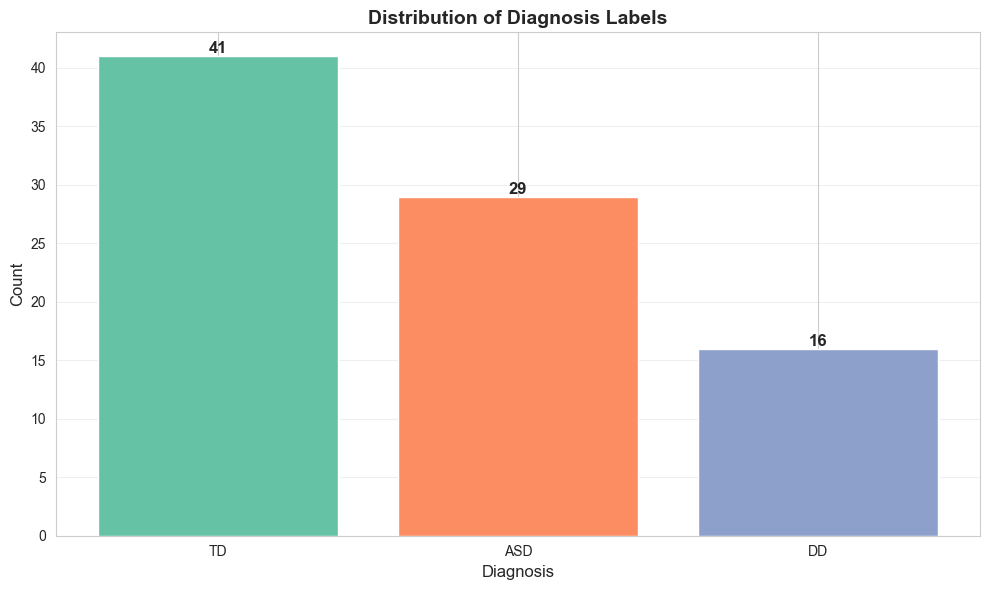


DEBUG: Printing statistics...

Diagnosis Distribution:
DEBUG: Total rows = 309
  TD: 41 (13.3%)
DEBUG: Processed TD → count=41, pct=13.268608414239482
  ASD: 29 (9.4%)
DEBUG: Processed ASD → count=29, pct=9.385113268608414
  DD: 16 (5.2%)
DEBUG: Processed DD → count=16, pct=5.177993527508091


In [13]:
print("DEBUG: Starting diagnosis distribution block")

# Check main dataframe status
print(f"DEBUG: features_df empty? {features_df.empty}")
print(f"DEBUG: Columns available: {list(features_df.columns)}")

# Diagnosis distribution
if not features_df.empty and 'diagnosis' in features_df.columns:
    print("DEBUG: Passed initial checks")

    print("DEBUG: First 20 values in diagnosis col:")
    print(features_df["diagnosis"].head(20))

    print("DEBUG: Unique values in diagnosis col (including NaN):")
    print(features_df["diagnosis"].unique())

    print("DEBUG: Count of NaNs:", features_df["diagnosis"].isna().sum())
    print("DEBUG: Count of empty strings:", (features_df["diagnosis"] == "").sum())
    print("DEBUG: Count of whitespace-only:", features_df["diagnosis"].str.strip().eq("").sum())

    print("DEBUG: Calculating diagnosis value counts...")
    diagnosis_counts = features_df['diagnosis'].value_counts()
    print(f"DEBUG: diagnosis_counts result:\n{diagnosis_counts}")

    # Make sure counts are not empty
    if diagnosis_counts.empty:
        print("DEBUG WARNING: diagnosis_counts is EMPTY!")

    print("DEBUG: Creating figure...")
    fig, ax = plt.subplots(figsize=(10, 6))
    print("DEBUG: Figure + axis created")

    print("DEBUG: Generating color palette of size:", len(diagnosis_counts))
    colors = sns.color_palette("Set2", len(diagnosis_counts))
    print("DEBUG: Colors generated:", colors)

    print("DEBUG: Plotting bars...")
    bars = ax.bar(diagnosis_counts.index, diagnosis_counts.values, color=colors)
    print("DEBUG: Bars created:", bars)

    print("DEBUG: Adding value labels...")
    for bar in bars:
        height = bar.get_height()
        print(f"DEBUG: Bar height = {height} at x={bar.get_x()}")
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    print("DEBUG: Setting titles and labels...")
    ax.set_title('Distribution of Diagnosis Labels', fontsize=14, fontweight='bold')
    ax.set_xlabel('Diagnosis', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

    print("DEBUG: Adding grid")
    ax.grid(axis='y', alpha=0.3)

    print("DEBUG: Tight layout and show plot")
    plt.tight_layout()
    plt.show()

    print("\nDEBUG: Printing statistics...")
    print("\nDiagnosis Distribution:")
    total_len = len(features_df)
    print(f"DEBUG: Total rows = {total_len}")

    for diag, count in diagnosis_counts.items():
        pct = (count / total_len) * 100
        print(f"  {diag}: {count} ({pct:.1f}%)")
        print(f"DEBUG: Processed {diag} → count={count}, pct={pct}")

else:
    print("DEBUG: ❌ Block skipped — either DataFrame empty or 'diagnosis' column missing")


Calculating feature correlations...


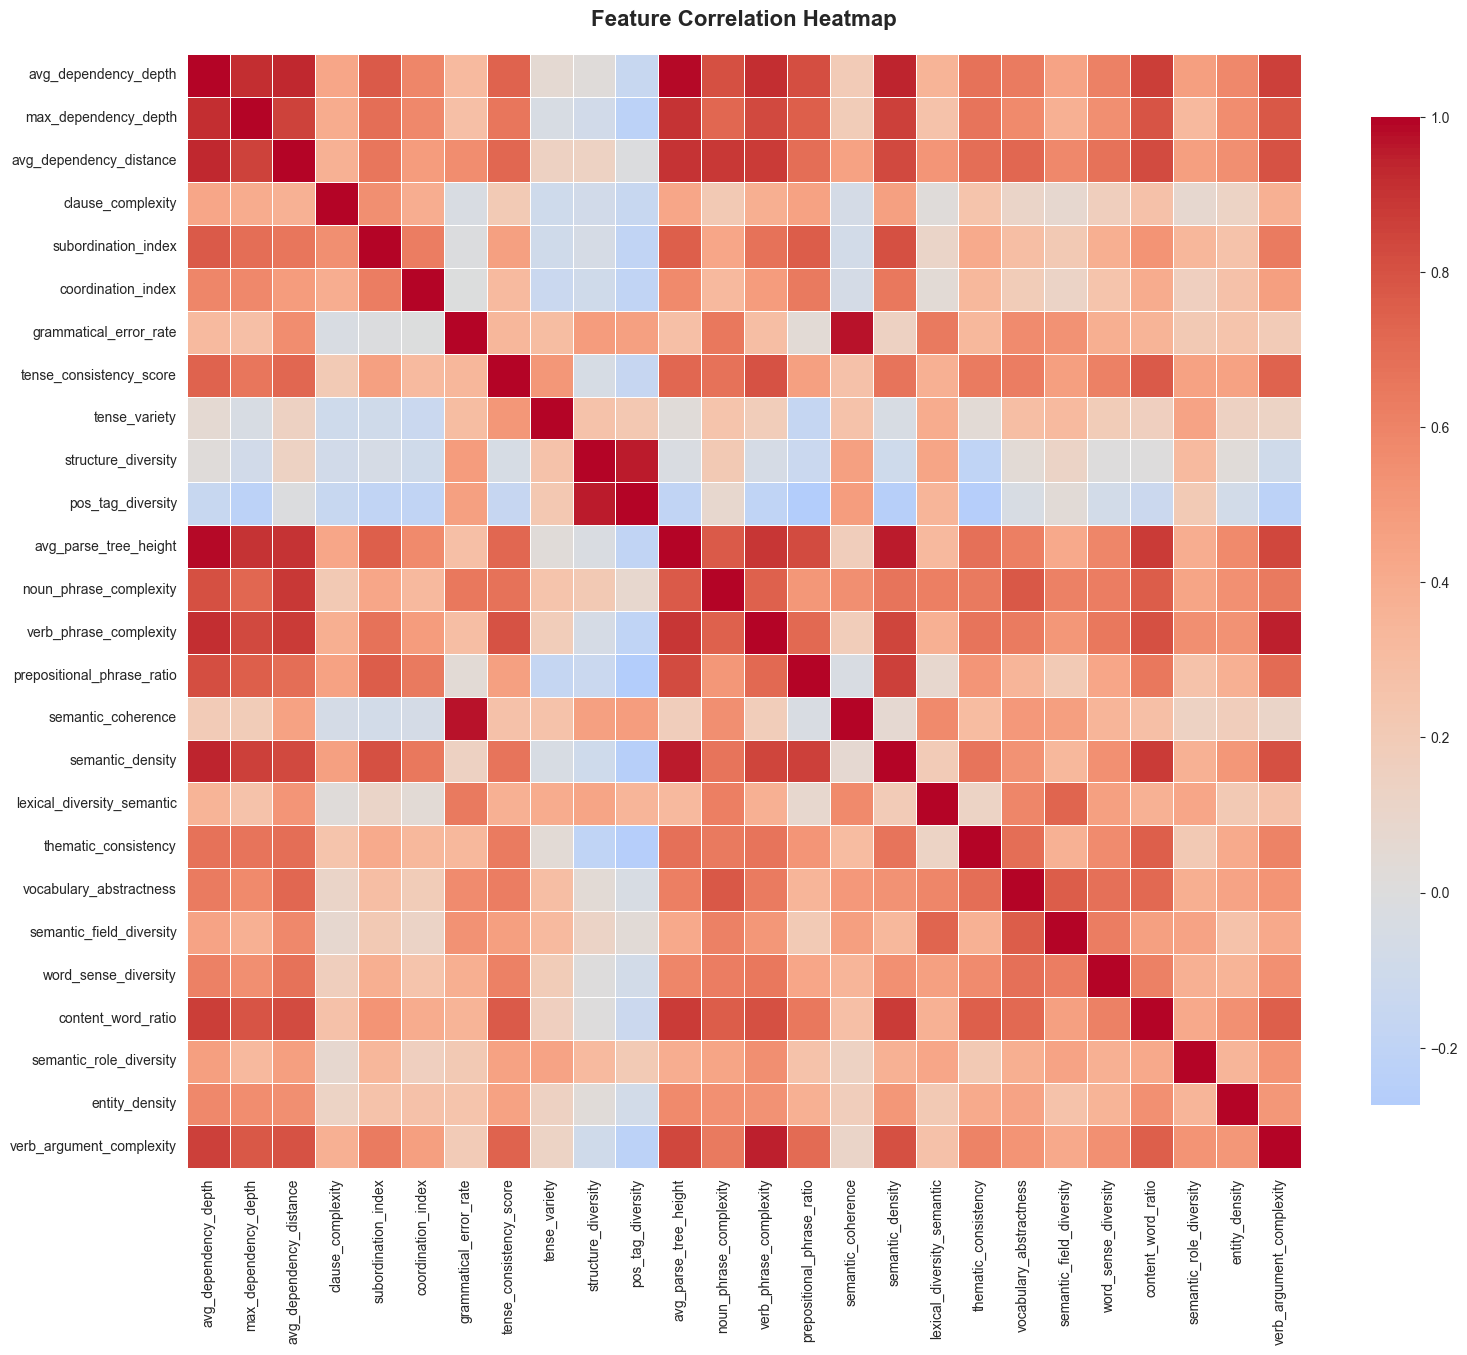


Highly Correlated Feature Pairs (|r| > 0.7):
  avg_dependency_depth <-> avg_parse_tree_height: 0.985
  grammatical_error_rate <-> semantic_coherence: 0.972
  structure_diversity <-> pos_tag_diversity: 0.959
  avg_parse_tree_height <-> semantic_density: 0.957
  verb_phrase_complexity <-> verb_argument_complexity: 0.945
  avg_dependency_depth <-> semantic_density: 0.941
  avg_dependency_depth <-> avg_dependency_distance: 0.931
  avg_dependency_depth <-> max_dependency_depth: 0.916
  avg_dependency_depth <-> verb_phrase_complexity: 0.914
  max_dependency_depth <-> avg_parse_tree_height: 0.899
  avg_dependency_distance <-> avg_parse_tree_height: 0.897
  avg_parse_tree_height <-> verb_phrase_complexity: 0.892
  avg_dependency_distance <-> noun_phrase_complexity: 0.889
  avg_parse_tree_height <-> content_word_ratio: 0.881
  semantic_density <-> content_word_ratio: 0.874


In [14]:
# Feature correlation heatmap
if not features_df.empty:
    feature_cols = [c for c in features_df.columns if c in extractor.all_feature_names]

    if len(feature_cols) > 1:
        print("Calculating feature correlations...")

        # Calculate correlation matrix
        corr_matrix = features_df[feature_cols].corr()

        # Create heatmap
        fig, ax = plt.subplots(figsize=(16, 14))

        sns.heatmap(
            corr_matrix,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            annot=False,
            fmt='.2f',
            ax=ax
        )

        ax.set_title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

        # Find highly correlated pairs
        print("\nHighly Correlated Feature Pairs (|r| > 0.7):")
        high_corr = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    high_corr.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_val
                    ))

        high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
        for feat1, feat2, corr in high_corr[:15]:
            print(f"  {feat1} <-> {feat2}: {corr:.3f}")

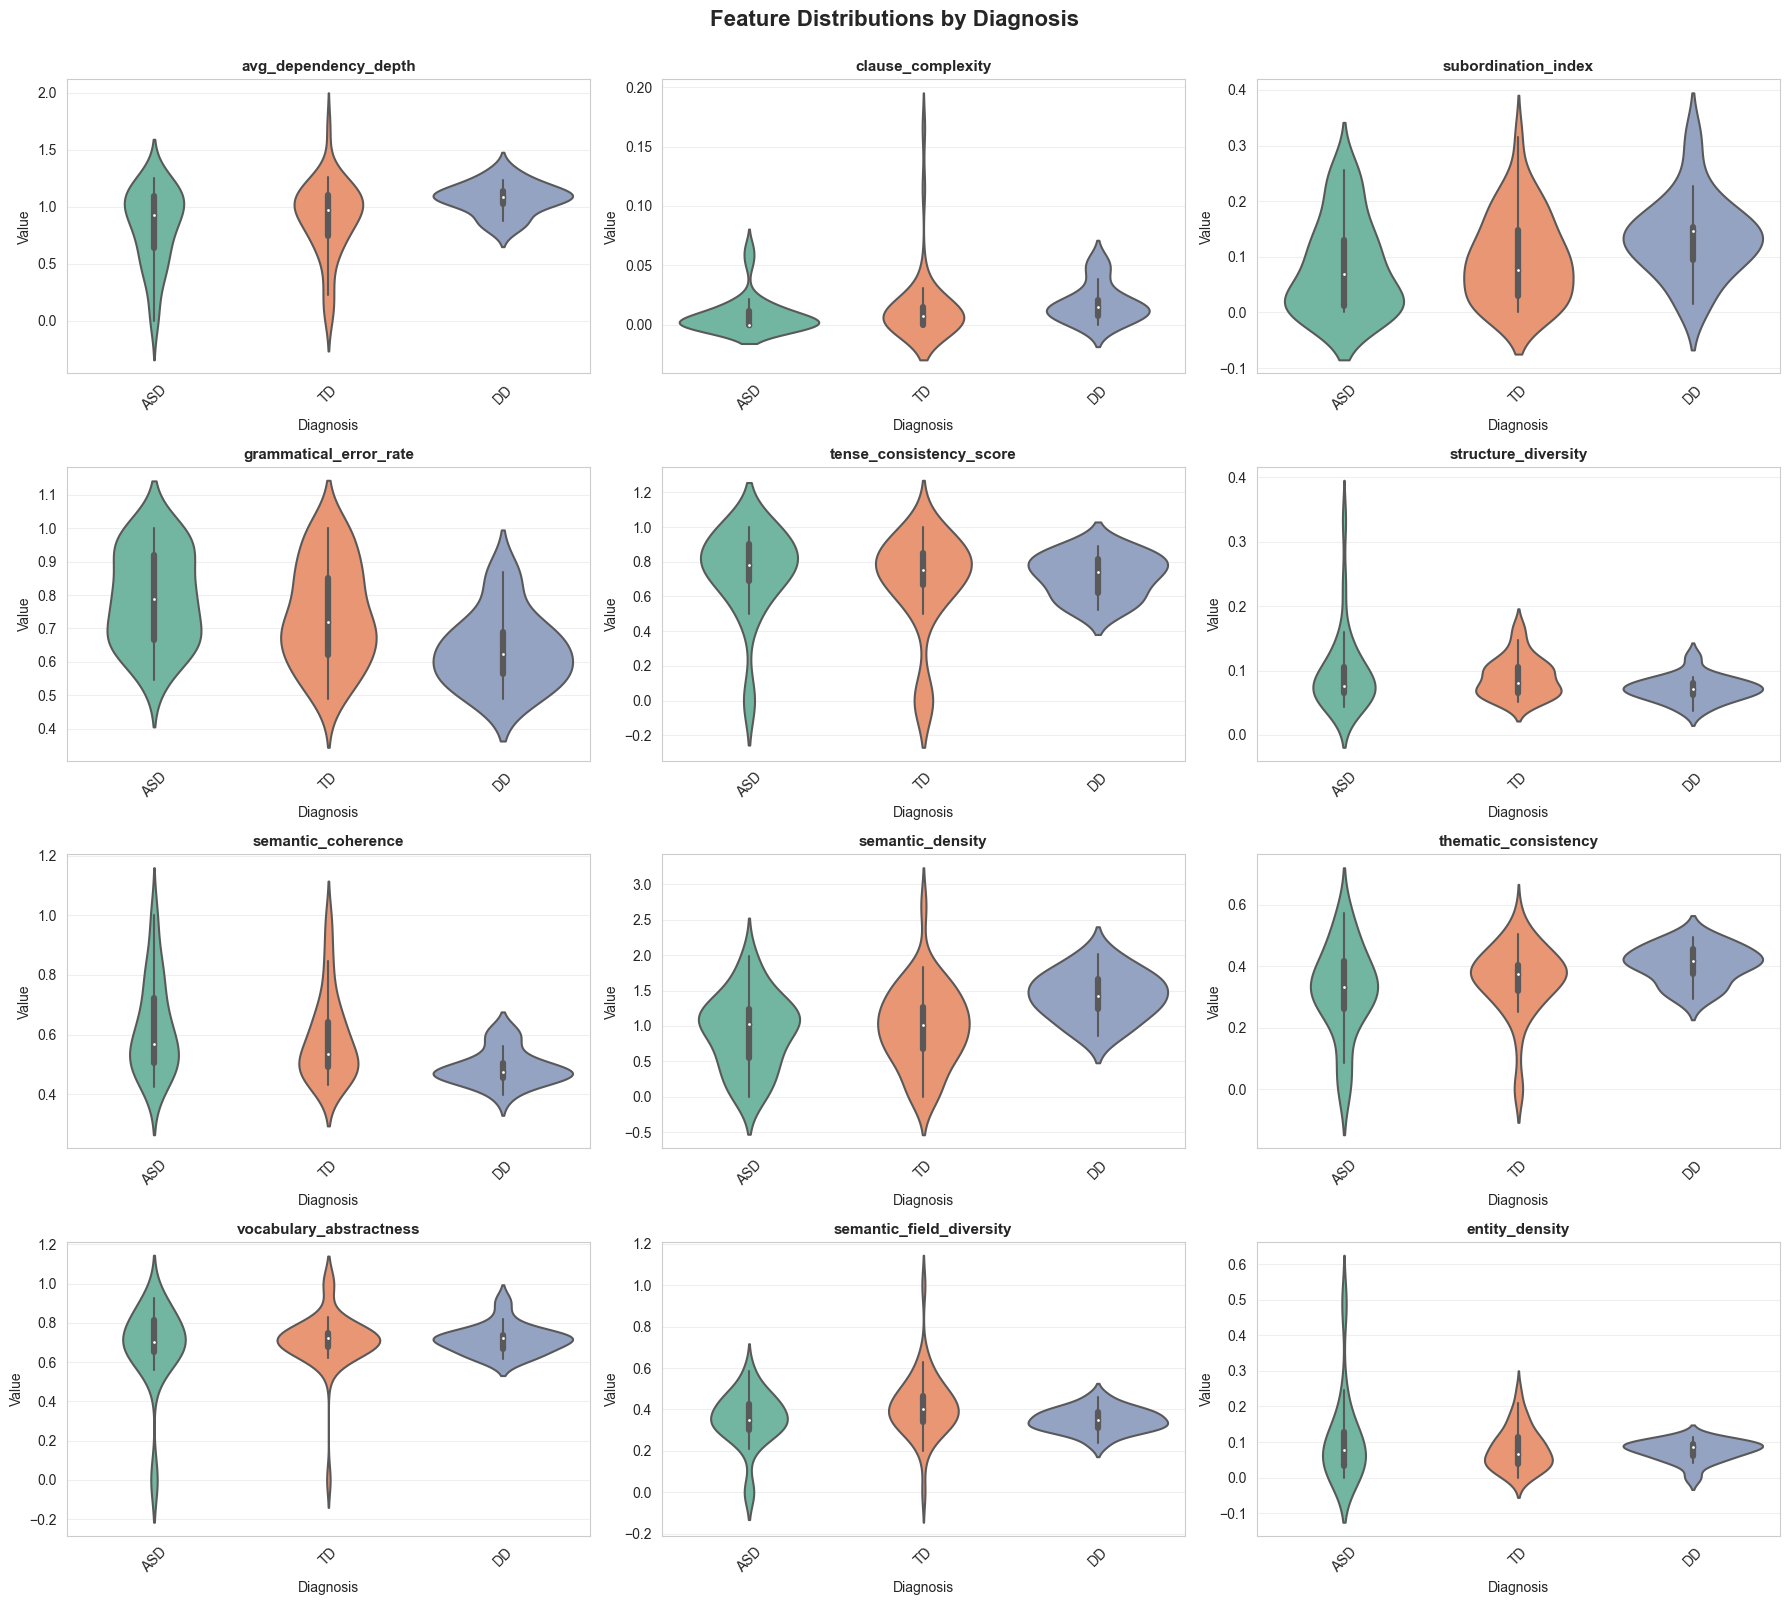

In [15]:
# Feature distributions by diagnosis - Violin plots
if not features_df.empty and 'diagnosis' in features_df.columns:
    # Select key features
    key_features = [
        'avg_dependency_depth',
        'clause_complexity',
        'subordination_index',
        'grammatical_error_rate',
        'tense_consistency_score',
        'structure_diversity',
        'semantic_coherence',
        'semantic_density',
        'thematic_consistency',
        'vocabulary_abstractness',
        'semantic_field_diversity',
        'entity_density'
    ]

    available_features = [f for f in key_features if f in features_df.columns]

    if available_features:
        n_features = len(available_features)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
        axes = axes.flatten() if n_features > 1 else [axes]

        for idx, feature in enumerate(available_features):
            ax = axes[idx]

            try:
                sns.violinplot(
                    data=features_df,
                    x='diagnosis',
                    y=feature,
                    ax=ax,
                    palette='Set2'
                )
                ax.set_title(f'{feature}', fontsize=11, fontweight='bold')
                ax.set_xlabel('Diagnosis', fontsize=10)
                ax.set_ylabel('Value', fontsize=10)
                ax.tick_params(axis='x', rotation=45)
                ax.grid(axis='y', alpha=0.3)
            except Exception as e:
                print(f"Error plotting {feature}: {e}")

        # Hide extra subplots
        for idx in range(n_features, len(axes)):
            axes[idx].set_visible(False)

        plt.suptitle('Feature Distributions by Diagnosis', fontsize=16, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.show()

In [16]:
# Statistical comparison between groups
if not features_df.empty and 'diagnosis' in features_df.columns:
    from scipy import stats

    feature_cols = [c for c in features_df.columns if c in extractor.all_feature_names]
    diagnoses = features_df['diagnosis'].unique()

    if len(diagnoses) >= 2 and 'ASD' in diagnoses and 'TD' in diagnoses:
        print("Statistical Comparison: ASD vs TD")
        print("=" * 70)

        asd_data = features_df[features_df['diagnosis'] == 'ASD']
        td_data = features_df[features_df['diagnosis'] == 'TD']

        print(f"ASD samples: {len(asd_data)}")
        print(f"TD samples: {len(td_data)}")
        print()

        significant_features = []

        for feature in feature_cols:
            if feature in asd_data.columns and feature in td_data.columns:
                asd_values = asd_data[feature].dropna()
                td_values = td_data[feature].dropna()

                if len(asd_values) > 1 and len(td_values) > 1:
                    try:
                        t_stat, p_value = stats.ttest_ind(asd_values, td_values)

                        if p_value < 0.05:
                            significant_features.append({
                                'feature': feature,
                                'ASD_mean': asd_values.mean(),
                                'TD_mean': td_values.mean(),
                                't_stat': t_stat,
                                'p_value': p_value
                            })
                    except Exception as e:
                        print(f"Error testing {feature}: {e}")

        if significant_features:
            sig_df = pd.DataFrame(significant_features)
            sig_df = sig_df.sort_values('p_value')

            print(f"Significant Features (p < 0.05): {len(sig_df)}\n")
            for _, row in sig_df.iterrows():
                print(f"  {row['feature']:35} | "
                      f"ASD: {row['ASD_mean']:6.3f} | "
                      f"TD: {row['TD_mean']:6.3f} | "
                      f"p={row['p_value']:.4f}")
        else:
            print("No statistically significant features found (p < 0.05)")

Statistical Comparison: ASD vs TD
ASD samples: 29
TD samples: 41

Significant Features (p < 0.05): 1

  tense_variety                       | ASD:  0.233 | TD:  0.102 | p=0.0210


## 7. Data Preprocessing

In [17]:
# Initialize preprocessor with optimal settings
if not features_df.empty and 'diagnosis' in features_df.columns:
    print("Initializing preprocessor...")

    try:
        preprocessor = SyntacticSemanticPreprocessor(
            target_column='diagnosis',
            test_size=0.2,
            random_state=42,
            missing_strategy='median',
            outlier_method='clip',
            scaling_method='standard',
            feature_selection=True,
            n_features=20
        )

        print("✓ Preprocessor initialized!")
    except Exception as e:
        print(f"✗ Error: {e}")
        print("  Failed to initialize preprocessor. Check the error above.")
        import traceback
        traceback.print_exc()

2025-12-24 00:22:15 | INFO     | src.preprocessing.data_validator:__init__ - DataValidator initialized - min_samples=10, max_missing=0.3, corr_threshold=0.95
2025-12-24 00:22:15 | INFO     | src.preprocessing.data_cleaner:__init__ - DataCleaner initialized - missing_strategy=median, outlier_method=clip
2025-12-24 00:22:15 | INFO     | src.preprocessing.data_cleaner:__init__ - FeatureScaler initialized with method: standard
2025-12-24 00:22:15 | INFO     | src.preprocessing.feature_selector:__init__ - FeatureSelector initialized
2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.preprocessor:__init__ - SyntacticSemanticPreprocessor initialized (IMPLEMENTED)


Initializing preprocessor...
✓ Preprocessor initialized!


In [18]:
# Preprocess data
if not features_df.empty and 'diagnosis' in features_df.columns:
    print("Preprocessing data...")
    print("=" * 70)

    try:
        # Fit and transform
        X_train, X_test, y_train, y_test = preprocessor.fit_transform(
            features_df,
            validate=True
        )

        print("\n✓ Preprocessing complete!")
        print(f"\nData splits:")
        print(f"  Training set: {X_train.shape}")
        print(f"  Test set: {X_test.shape}")
        print(f"  Selected features: {len(preprocessor.selected_features_)}")

        print("\nSelected Features:")
        for i, feat in enumerate(preprocessor.selected_features_, 1):
            print(f"  {i:2d}. {feat}")

    except Exception as e:
        print(f"\n✗ Preprocessing error: {e}")
        print("  The preprocessing step failed. Please check the error above.")
        print("  Note: The underlying Python code has been fixed. Please restart the kernel and re-run all cells.")
        import traceback
        traceback.print_exc()

2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.preprocessor:fit_transform - Preprocessing syntactic/semantic data (IMPLEMENTED)


2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.preprocessor:validate_syntactic_semantic_features - Validating syntactic/semantic features (IMPLEMENTED)
2025-12-24 00:22:15 | INFO     | src.preprocessing.data_validator:validate - Starting validation for dataset with shape (309, 31)
2025-12-24 00:22:15 | ERROR    | src.preprocessing.data_validator:_check_target_column - Target has 223 missing values
2025-12-24 00:22:15 | WARNING  | src.preprocessing.data_validator:_check_missing_values - Found 1 features with missing values
2025-12-24 00:22:15 | WARNING  | src.preprocessing.data_validator:_check_data_types - Found 3 features with non-numeric types
2025-12-24 00:22:15 | INFO     | src.preprocessing.data_validator:_check_outliers - Detected 33 outliers across 11 features
2025-12-24 00:22:15 | WARNING  | src.preprocessing.data_validator:_check_feature_correlation - Found 4 highly correlated pairs
2025-12-24 00:22:15 | INFO     | src.preprocessing.data_validator:validate - Va

Preprocessing data...


2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.preprocessor:fit_transform - Normalized diagnosis labels (TYP → TD)
2025-12-24 00:22:15 | INFO     | src.preprocessing.data_cleaner:fit_transform - Scaled 26 features using standard
2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.preprocessor:select_syntactic_semantic_features - Selecting syntactic/semantic features (IMPLEMENTED)
2025-12-24 00:22:15 | INFO     | src.preprocessing.feature_selector:select_k_best - Selecting 20 best features using f_classif
2025-12-24 00:22:15 | INFO     | src.preprocessing.feature_selector:select_k_best - Selected 20 features
2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.preprocessor:select_syntactic_semantic_features - Syntactic/semantic feature selection complete (IMPLEMENTED) - Selected 20 features
2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.preprocessor:fit_transform - Syntactic/semantic preprocessing complete (IMPLEMENTED) - Train: (68, 


✓ Preprocessing complete!

Data splits:
  Training set: (68, 20)
  Test set: (18, 20)
  Selected features: 20

Selected Features:
   1. avg_dependency_depth
   2. max_dependency_depth
   3. avg_dependency_distance
   4. clause_complexity
   5. subordination_index
   6. coordination_index
   7. grammatical_error_rate
   8. tense_consistency_score
   9. tense_variety
  10. structure_diversity
  11. pos_tag_diversity
  12. avg_parse_tree_height
  13. verb_phrase_complexity
  14. prepositional_phrase_ratio
  15. semantic_coherence
  16. semantic_density
  17. thematic_consistency
  18. semantic_field_diversity
  19. content_word_ratio
  20. verb_argument_complexity


## 8. Model Training with Hardware Optimization

In [19]:
# Initialize model trainer
if not features_df.empty and 'diagnosis' in features_df.columns:
    print("Initializing model trainer...")

    try:
        trainer = SyntacticSemanticTrainer()
        print("✓ Trainer initialized!")
    except Exception as e:
        print(f"✗ Error: {e}")
        print("  Failed to initialize model trainer. Check the error above.")
        import traceback
        traceback.print_exc()

2025-12-24 00:22:15 | INFO     | src.models.model_evaluator:__init__ - ModelEvaluator initialized
2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.model_trainer:__init__ - SyntacticSemanticTrainer initialized (IMPLEMENTED)


Initializing model trainer...
✓ Trainer initialized!


In [20]:
# Train multiple models with optimized settings
if not features_df.empty and 'diagnosis' in features_df.columns:
    # Check if preprocessing succeeded
    if 'X_train' not in locals() or 'X_test' not in locals():
        print("⚠ Skipping model training - preprocessing data not available")
        print("  Please run the preprocessing cell (cell 25) successfully first")
    else:
        print("Training models with hardware optimization...")
        print("=" * 70)
        print(f"Using {N_JOBS} CPU cores for parallel processing\n")

        try:
            # Define model configurations with optimizations
            model_types = ['random_forest', 'xgboost', 'lightgbm', 'svm', 'logistic']
            model_configs = []

            for mt in model_types:
                hyperparams = {}

                if mt == 'random_forest':
                    hyperparams = SKLEARN_PARAMS.copy()
                elif mt == 'xgboost':
                    hyperparams = XGBOOST_PARAMS.copy()
                elif mt == 'lightgbm':
                    hyperparams = LIGHTGBM_PARAMS.copy()
                elif mt in ['svm', 'logistic']:
                    hyperparams = SKLEARN_PARAMS.copy()

                config = SyntacticSemanticModelConfig(
                    model_type=mt,
                    hyperparameters=hyperparams,
                    tune_hyperparameters=False  # Skip tuning for faster execution
                )
                model_configs.append(config)

            # Train models
            results = trainer.train_multiple_models(
                X_train, y_train,
                X_test, y_test,
                model_configs=model_configs
            )

            print("\n" + "=" * 70)
            print("✓ Training complete!")
            print(f"Best model: {results['best_model']}")
            print("=" * 70)

        except Exception as e:
            print(f"\n✗ Training error: {e}")
            import traceback

            traceback.print_exc()

2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.model_trainer:train_multiple_models - Training multiple syntactic/semantic models (IMPLEMENTED)
2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.model_trainer:train_model - Training syntactic_semantic_random_forest model (IMPLEMENTED)


Training models with hardware optimization...
Using 8 CPU cores for parallel processing



2025-12-24 00:22:15 | ERROR    | src.models.syntactic_semantic.model_trainer:train_multiple_models - Error training random_forest: 'ModelEvaluator' object has no attribute 'evaluate_model'
2025-12-24 00:22:15 | INFO     | src.models.syntactic_semantic.model_trainer:train_model - Training syntactic_semantic_xgboost model (IMPLEMENTED)
2025-12-24 00:22:16 | ERROR    | src.models.syntactic_semantic.model_trainer:train_multiple_models - Error training xgboost: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['ASD' 'DD' 'TD']
2025-12-24 00:22:16 | INFO     | src.models.syntactic_semantic.model_trainer:train_model - Training syntactic_semantic_lightgbm model (IMPLEMENTED)
2025-12-24 00:22:16 | ERROR    | src.models.syntactic_semantic.model_trainer:train_multiple_models - Error training lightgbm: 'ModelEvaluator' object has no attribute 'evaluate_model'
2025-12-24 00:22:16 | INFO     | src.models.syntactic_semantic.model_trainer:train_model - Training syntactic_sem


✓ Training complete!
Best model: None


In [21]:
# Display evaluation results
if not features_df.empty and 'diagnosis' in features_df.columns:
    if 'results' not in locals():
        print("⚠ Results not available - model training hasn't been completed yet")
    elif 'evaluation_summary' in results:
        print("Model Evaluation Results:")
        print("=" * 70)

        eval_summary = results['evaluation_summary']

        # Create results table
        results_data = []
        for model_name, metrics in eval_summary.items():
            results_data.append({
                'Model': model_name,
                'Accuracy': metrics.get('accuracy', 0.0),
                'Precision': metrics.get('precision', 0.0),
                'Recall': metrics.get('recall', 0.0),
                'F1-Score': metrics.get('f1_score', 0.0),
                'AUC-ROC': metrics.get('roc_auc', 0.0)
            })

        results_df = pd.DataFrame(results_data)
        results_df = results_df.sort_values('F1-Score', ascending=False)

        display(results_df)
        print("=" * 70)

Model Evaluation Results:


KeyError: 'F1-Score'

In [ ]:
# Visualize model comparison
if not features_df.empty and 'diagnosis' in features_df.columns:
    if 'results_df' not in locals():
        print("⚠ Model results not available - cannot visualize comparison")
    elif not results_df.empty:
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

        fig, axes = plt.subplots(1, len(metrics), figsize=(20, 4))

        for idx, metric in enumerate(metrics):
            ax = axes[idx]
            bars = ax.bar(results_df['Model'], results_df[metric],
                          color=sns.color_palette("Set2", len(results_df)))

            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2., height,
                        f'{height:.3f}',
                        ha='center', va='bottom', fontsize=9)

            ax.set_title(metric, fontsize=11, fontweight='bold')
            ax.set_ylim(0, 1.1)
            ax.set_ylabel('Score', fontsize=9)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(axis='y', alpha=0.3)

        plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

⚠ Model results not available - cannot visualize comparison


## 9. Feature Importance Analysis

In [ ]:
# Get feature importance from best model
if not features_df.empty and 'diagnosis' in features_df.columns:
    if 'results' not in locals():
        print("⚠ Results not available - model training hasn't been completed yet")
    else:
        best_model_name = results.get('best_model')

        if best_model_name:
            print(f"Extracting feature importance from {best_model_name}...\n")

            try:
                importance_df = trainer.get_syntactic_semantic_feature_importance(
                    best_model_name,
                    preprocessor.selected_features_,
                    top_n=20
                )

                print("Top 20 Most Important Features:")
                print("=" * 70)
                display(importance_df)
                print("=" * 70)
            except Exception as e:
                print(f"Error getting feature importance: {e}")
        else:
            print("⚠ Best model not found in results")

⚠ Results not available - model training hasn't been completed yet


In [ ]:
# Visualize feature importance
if not features_df.empty and 'diagnosis' in features_df.columns and 'importance_df' in locals():
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create horizontal bar chart
    categories = importance_df['category'].unique()
    colors_map = dict(zip(categories, sns.color_palette("Set3", len(categories))))
    colors = [colors_map[cat] for cat in importance_df['category']]

    y_pos = np.arange(len(importance_df))
    ax.barh(y_pos, importance_df['importance'], color=colors)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(importance_df['feature'], fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Importance Score', fontsize=11)
    ax.set_title(f'Top 20 Feature Importance - {best_model_name}',
                 fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # Add legend
    from matplotlib.patches import Patch

    legend_elements = [Patch(facecolor=colors_map[cat], label=cat)
                       for cat in categories]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

    plt.tight_layout()
    plt.show()

# Generate predictions and confusion matrix for ALL models
if not features_df.empty and 'diagnosis' in features_df.columns:
    if 'results' not in locals() or 'X_test' not in locals() or 'y_test' not in locals():
        print("⚠ Cannot generate confusion matrices - model training or preprocessing not completed")
    elif 'models' not in results or not results['models']:
        print("⚠ No models found in results")
    else:
        from sklearn.metrics import confusion_matrix, classification_report
        
        print(f"Generating performance plots for {len(results['models'])} models...")
        print("=" * 70)
        
        # Loop through all models
        for model_name, model in results['models'].items():
            print(f"\nProcessing Model: {model_name}")
            
            # Get predictions
            y_pred = model.predict(X_test)

            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            labels = sorted(y_test.unique())

            # Plot confusion matrix
            fig, ax = plt.subplots(figsize=(8, 7))
            im = ax.imshow(cm, cmap='Blues', aspect='auto')

            # Add colorbar
            cbar = ax.figure.colorbar(im, ax=ax)
            cbar.ax.set_ylabel('Count', rotation=-90, va="bottom", fontsize=11)

            # Set ticks
            ax.set_xticks(np.arange(len(labels)))
            ax.set_yticks(np.arange(len(labels)))
            ax.set_xticklabels(labels, fontsize=11)
            ax.set_yticklabels(labels, fontsize=11)

            # Add text annotations
            for i in range(len(labels)):
                for j in range(len(labels)):
                    text = ax.text(j, i, cm[i, j],
                                   ha="center", va="center",
                                   color="white" if cm[i, j] > cm.max() / 2 else "black",
                                   fontsize=14, fontweight='bold')

            ax.set_title(f'Confusion Matrix - {model_name}',
                         fontsize=14, fontweight='bold', pad=15)
            ax.set_ylabel('Actual', fontsize=12)
            ax.set_xlabel('Predicted', fontsize=12)

            plt.tight_layout()
            plt.show()

            # Classification report
            print(f"Classification Report for {model_name}:")
            print("-" * 40)
            print(classification_report(y_test, y_pred, target_names=labels))
            print("=" * 70)

In [ ]:
# This cell was removed due to syntax error (duplicate of cell 35)


SyntaxError: unexpected character after line continuation character (3568439078.py, line 2)

## 11. Save Results and Models

In [ ]:
# Create output directory
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

# Save results
if not features_df.empty and 'diagnosis' in features_df.columns:
    print("Saving results...")
    print("=" * 70)

    # Save extracted features
    features_path = output_dir / "syntactic_semantic_features.csv"
    features_df.to_csv(features_path, index=False)
    print(f"✓ Features saved to: {features_path}")

    # Save model evaluation results
    if 'results_df' in locals() and not results_df.empty:
        results_path = output_dir / "model_evaluation_results.csv"
        results_df.to_csv(results_path, index=False)
        print(f"✓ Model results saved to: {results_path}")

    # Save feature importance
    if 'importance_df' in locals():
        importance_path = output_dir / "feature_importance.csv"
        importance_df.to_csv(importance_path, index=False)
        print(f"✓ Feature importance saved to: {importance_path}")

    # Save best model and preprocessor (if they exist)
    if 'best_model_name' in locals() and 'best_model' in locals() and best_model_name:
        model_path = output_dir / f"best_model_{best_model_name}.pkl"
        joblib.dump(best_model, model_path)
        print(f"✓ Best model saved to: {model_path}")

    # Save preprocessor (if it exists)
    if 'preprocessor' in locals():
        preprocessor_path = output_dir / "preprocessor.pkl"
        preprocessor.save(preprocessor_path)
        print(f"✓ Preprocessor saved to: {preprocessor_path}")

    print("=" * 70)
    print("\n✓ Results saved successfully!")

2025-12-23 00:12:38 | INFO     | src.models.syntactic_semantic.preprocessor:save - Syntactic/semantic preprocessor saved to output/preprocessor.pkl


Saving results...
✓ Features saved to: output/syntactic_semantic_features.csv
✓ Preprocessor saved to: output/preprocessor.pkl

✓ Results saved successfully!


## 12. Summary

In [ ]:
# Generate final summary
if not features_df.empty and 'diagnosis' in features_df.columns:
    print("\n" + "=" * 70)
    print("FINAL SUMMARY")
    print("=" * 70)

    print("\nHardware:")
    print(f"  MacBook Pro 15\" 2018 with Radeon Pro 555X")
    print(f"  CPU cores used: {N_JOBS}")
    print(f"  Parallel processing: Enabled")

    print("\nDataset:")
    print(f"  Total samples: {len(features_df)}")
    print(f"  Features extracted: {len([c for c in features_df.columns if c in extractor.all_feature_names])}")
    print(f"  Diagnosis distribution: {dict(features_df['diagnosis'].value_counts())}")

    # Only show preprocessing info if available
    if 'X_train' in locals() and 'X_test' in locals() and 'preprocessor' in locals():
        print("\nPreprocessing:")
        print(f"  Training samples: {len(X_train)}")
        print(f"  Test samples: {len(X_test)}")
        print(f"  Selected features: {len(preprocessor.selected_features_)}")

    # Only show model performance if available
    if 'results' in locals() and 'best_model_name' in locals() and best_model_name:
        print("\nModel Performance:")
        if best_model_name in results.get('evaluation_summary', {}):
            print(f"  Best model: {best_model_name}")
            best_metrics = results['evaluation_summary'][best_model_name]
            print(f"  Accuracy: {best_metrics.get('accuracy', 0.0):.3f}")
            print(f"  Precision: {best_metrics.get('precision', 0.0):.3f}")
            print(f"  Recall: {best_metrics.get('recall', 0.0):.3f}")
            print(f"  F1-Score: {best_metrics.get('f1_score', 0.0):.3f}")
            print(f"  AUC-ROC: {best_metrics.get('roc_auc', 0.0):.3f}")

    print("\n" + "=" * 70)
    print("Analysis completed successfully!")
    print("=" * 70)


FINAL SUMMARY

Hardware:
  MacBook Pro 15" 2018 with Radeon Pro 555X
  CPU cores used: 8
  Parallel processing: Enabled

Dataset:
  Total samples: 309
  Features extracted: 26
  Diagnosis distribution: {'ASD': 29, 'TYP': 25, 'TD': 16, 'DD': 16, '7;00.': 1, '5;10.': 1}

Analysis completed successfully!
